### NMF-based SFH, metallicity, dust slope and , stellar mass, redshift

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi

In [3]:
# kuaizi.set_matplotlib(style='nature', usetex=False)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [4]:
import fsps
import sedpy
from sedpy.observate import load_filters
import prospect
from prospect.sources.constants import cosmo #WMAP9
import exspect
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')

In [5]:
from popsed import mock
from popsed.sfh import params_to_sfh, parametric_sfr, parametric_mwa

In [6]:
# SDSS filters
sdss = ['sdss_{0}0'.format(b) for b in 'ugriz']

### Let's think about the prior distributions for sampling traning SEDs

In order to cover SDSS five bands, we need spectrum covering 1000 A to 60000 A. But we split the wavelength range into several pieces: `'.w1000_2000', '.w2000_3600', '.w3600_5500', '.w5500_7410', '.w7410_60000'`


Let's sample the prior, instead of doing a grid search.

IMF: Chabrier (2003) (in FSPS, imf=1)

$\beta_i \sim \rm Dirichlet$ (NMF coeffs)

$\log Z [Z_\odot] \sim \rm Uniform[-2, 0.5]$

$\log\, M_\star\ [M_\odot] = 0 $

$z=0.0$. However, there should be a constraint on redshift and tage in `speculator`.

$\hat{\tau}_2 \sim \mathcal{N}(0.3, 1^2)$ with truncations at [0, 4], this is the `dust2` parameter. See Conroy09a.

In [133]:
from popsed import prior, models

In [572]:
model = models.NMF()
model._ssp_initiate()
# wavelength range set to cover GALEX FUV to WISE W2
w_fsps = model._ssp.wavelengths
wmin, wmax = 1000., 60000.
wlim = (w_fsps >= wmin) & (w_fsps <= wmax)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index


In [140]:
ncomp = 4
priors = prior.load_priors([
        prior.UniformPrior(0.0, 0.0, label='logmstar'),   # Log stellar mass, in M_sun
        prior.FlatDirichletPrior(ncomp, label='beta'),    # flat dirichilet priors for SFH
        prior.UniformPrior(0, 0.5, label='fburst'),       # uniform priors on the mass fraction of burst
        prior.UniformPrior(1e-2, 13.27, label='tburst'),  # uniform priors on star-burst lookback time
        prior.UniformPrior(-2.6, 0.3, label='logzsol'),   # uniform priors on log-metallicity, absolute Z
        prior.UniformPrior(0., 3., label='dust1'),        # uniform priors on dust1 
        prior.UniformPrior(0., 3., label='dust2'),        # uniform priors on dust2
        prior.UniformPrior(-3., 1., label='dust_index'),  # uniform priors on dust_index
        prior.UniformPrior(0., 1, label='redshift')       # uniformly sample redshift
        ])

In [141]:
N_samples = 1000
tt = np.array([priors.transform(priors.sample()) for i in range(N_samples)])
tage = model.cosmo.age(tt[:, -1:]).value # convert redshift to age

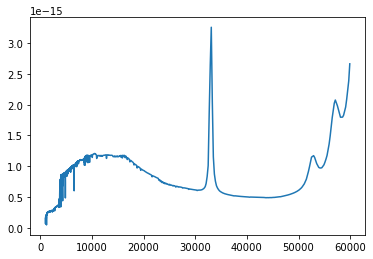

In [574]:
for i in range(1):
    wave, spec = model._fsps(tt[i, :-1], tage[i])
    wave = wave[wlim]
    spec = spec[wlim]
    plt.plot(wave, spec)

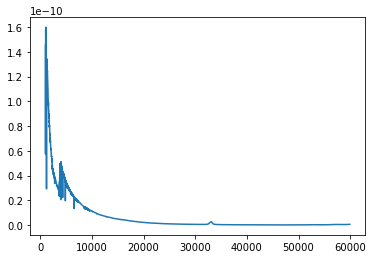

In [579]:
plt.plot(wave, spec * to_cgs_at_10pc * lightspeed / wave**2)

In [580]:
spec_aa = spec * to_cgs_at_10pc * lightspeed / wave**2

In [582]:
maggies = np.trapz(
    (wave * spec_aa / dfactor)[None, :] * transmission_effiency[None, :]
     , wave) / ab_zero_counts
-2.5 * np.log10(maggies)

array([[6.10316296, 5.30467549, 5.15523358, 5.05414597, 4.99588508]])

In [584]:
filt.ab_mag(wave, spec_aa)

6.103173821151061

In [611]:
# divide spectra into wavelength bins
for i in [1, 2, 3, 'test']:
    fspectrum = f'./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seed{i}.npy'
    logspectra = np.load(fspectrum)
    wave = np.load('./fsps.wavelength.npy')
    
    wave_bin00 = (wave >= 1000) & (wave < 2000)
    wave_bin0 = (wave >= 2000) & (wave < 3600)
    wave_bin1 = (wave >= 3600) & (wave < 5500)
    wave_bin2 = (wave >= 5500) & (wave < 7410)
    wave_bin3 = (wave >= 7410) & (wave < 60000)

    np.save(fspectrum.replace('.npy', '.w1000_2000.npy'),
            np.array(logspectra)[:, wave_bin00])
    np.save(fspectrum.replace('.npy', '.w2000_3600.npy'),
            np.array(logspectra)[:, wave_bin0])
    np.save(fspectrum.replace('.npy', '.w3600_5500.npy'),
            np.array(logspectra)[:, wave_bin1])
    np.save(fspectrum.replace('.npy', '.w5500_7410.npy'),
            np.array(logspectra)[:, wave_bin2])
    np.save(fspectrum.replace('.npy', '.w7410_60000.npy'),
            np.array(logspectra)[:, wave_bin3])

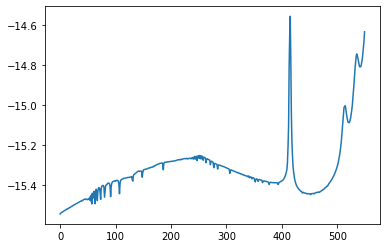

In [616]:
plt.plot(np.load('./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seed1.w7410_60000.npy')[5])

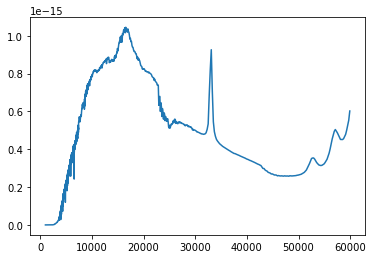

In [627]:
plt.plot(wave, 10**np.load('./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seedtest.npy')[5])

In [145]:
# get magnitude from a spectrum
lightspeed = 2.998e18  # AA/s
jansky_cgs = 1e-23

In [163]:
from sedpy import observate
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d

In [213]:
wave, spec = model._fsps(tt[-1, :-1], tage[-1])

In [217]:
x = wave
filterset = sdss

# transmission efficiency
_epsilon = np.zeros((len(filterset), len(x)))
_zero_counts = np.zeros(len(filterset))
filters = observate.load_filters(filterset)
for i in range(len(filterset)):
    _epsilon[i] = interp1d(filters[i].wavelength,
                           filters[i].transmission, 
                           bounds_error=False,
                                   fill_value=0)(x)
    _zero_counts[i] = filters[i].ab_zero_counts
filterset = filterset
transmission_effiency = _epsilon
ab_zero_counts = _zero_counts

In [228]:
_spec = spec * lightspeed / wave**2 * (3631 * jansky_cgs)  # in cgs/AA units
maggies = np.trapz(
    ((wave * _spec)[None, :] * transmission_effiency[None, :]
     ), wave) / ab_zero_counts

In [229]:
maggies

array([[2.18486742e-18, 9.90786290e-17, 4.17720450e-16, 7.33475258e-16,
        9.97269066e-16]])

In [230]:
-2.5 * np.log10(maggies)

array([[44.15143728, 40.01005003, 38.44778566, 37.83653633, 37.50296913]])

In [185]:
import astropy.units as u

In [186]:
u.Jansky

Unit("Jy")

In [ ]:
Fν = 3631 Jy

In [193]:
(u.L_sun * u.Hz**-1 * u.m**-2).to(u.Jy)

3.8279999999999997e+52

In [199]:
spec

array([9.20356217e-38, 1.69433507e-36, 1.51969460e-35, ...,
       2.75924113e-06, 2.92673360e-06, 3.24597888e-06])

In [235]:
model._ssp.get_mags(tage=11, redshift=0.001, bands=['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z'])

array([41.73142061, 36.99418548, 35.13731568, 34.39632207, 33.96302571])

In [ ]:
# divide spectra into wavelength bins
wave_bin00= (wave >= 1000) & (wave < 2000) 
wave_bin0 = (wave >= 2000) & (wave < 3600) 
wave_bin1 = (wave >= 3600) & (wave < 5500) 
wave_bin2 = (wave >= 5500) & (wave < 7410) 
wave_bin3 = (wave >= 7410) & (wave < 60000)

np.save(fspectrum.replace('.npy', '.w1000_2000.npy'), np.array(logspectra)[:,wave_bin00])
np.save(fspectrum.replace('.npy', '.w2000_3600.npy'), np.array(logspectra)[:,wave_bin0])
np.save(fspectrum.replace('.npy', '.w3600_5500.npy'), np.array(logspectra)[:,wave_bin1])
np.save(fspectrum.replace('.npy', '.w5500_7410.npy'), np.array(logspectra)[:,wave_bin2])
np.save(fspectrum.replace('.npy', '.w7410_60000.npy'), np.array(logspectra)[:,wave_bin3])

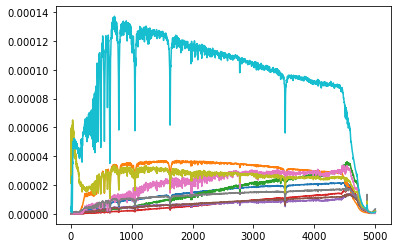

In [251]:
plt.plot(10**np.load('./train_sed/fsps.NMF.v0.1.log10spectrum.seed1.npy').T)

In [272]:
model._ssp.params['zred']

0.0

In [171]:
old_specs = 10**np.load('./train_sed/fsps.TZD.v0.1.log10spectrum.seed1.npy')

In [179]:
old_params = np.load('./train_sed/fsps.TZD.v0.1.theta.seed1.npy')

In [180]:
old_params[0]

array([9.03937708, 0.27375495, 0.19681437, 1.33428083, 1.        ,
       0.        ])

(2000.0, 7000.0)

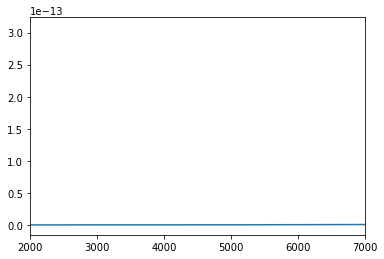

In [212]:
plt.plot(np.arange(1000, 15000, 2), old_specs[0] * lightspeed / np.arange(1000, 15000, 2)**2 * (3631 * jansky_cgs))
# plt.plot(wave, spec)

# plt.xlim(2000, 7000)

#plt.ylim(0, 1e-3)

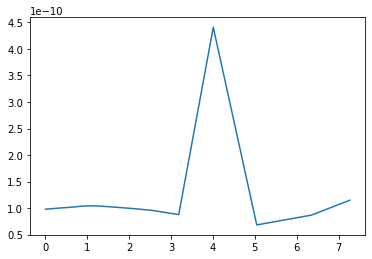

In [108]:
t, sfh = model.SFH(tt[0][:-1], tage=tage[0])
plt.plot(0.5 * (t[:-1] + t[1:]), sfh)

(0.0, 0.0001)

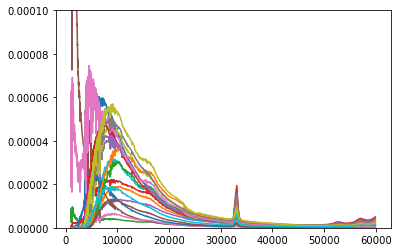

In [550]:
specs = np.load('./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seedtest.npy')
wave = np.load('./fsps.wavelength.npy')
[plt.plot(wave, 10**_spec) for _spec in specs]
plt.ylim(0, 1e-4)

In [559]:
maggies = np.trapz(
    (wave * 10**specs[4] / dfactor * to_cgs_at_10pc)[None, :] * transmission_effiency[None, :]
     , wave) / ab_zero_counts
-2.5 * np.log10(maggies) - 10

array([[19.35126585, 17.12958543, 15.82268853, 15.02854842, 14.46287023]])

In [590]:
wave, spec = model._ssp.get_spectrum(tage=10, peraa=False)
wmin, wmax = 1000., 60000.
wlim = (w_fsps >= wmin) & (w_fsps <= wmax)
wave = wave[wlim]
spec = spec[wlim]

x = wave
filterset = sdss

# transmission efficiency
_epsilon = np.zeros((len(filterset), len(x)))
_zero_counts = np.zeros(len(filterset))
filters = observate.load_filters(filterset)
for i in range(len(filterset)):
    _epsilon[i] = interp1d(filters[i].wavelength,
                           filters[i].transmission, 
                           bounds_error=False,
                                   fill_value=0)(x)
    _zero_counts[i] = filters[i].ab_zero_counts
filterset = filterset
transmission_effiency = _epsilon
ab_zero_counts = _zero_counts

In [568]:
ab_gnu = 3.631e-20  # AB reference spctrum in erg/s/cm^2/Hz
cosmo = FlatLambdaCDM(71.9, 0.3)
redshift = 1e-5
distance = cosmo.luminosity_distance(redshift)

dfactor = (1e-5 * 1e5)**2 / (1 + redshift)

# Useful constants
lsun = 3.846e33  # erg/s
pc = 3.085677581467192e18  # in cm
# value to go from L_sun/AA to erg/s/cm^2/AA at 10pc
to_cgs_at_10pc = lsun / (4.0 * np.pi * (pc*10)**2)

In [563]:
a = model._ssp.get_mags(tage=10, redshift=0, bands=[f'sdss_{filt}' for filt in 'ugriz'])
a

array([13.49895355,  8.79774247,  6.95554641,  6.22038801,  5.79331451])

In [564]:
filters = observate.load_filters([f'sdss_{filt}0' for filt in 'ugriz'])

In [570]:
b = np.array([filt.ab_mag(wave, spec / dfactor * to_cgs_at_10pc) for filt in filters])
b

array([13.49609454,  8.7948663 ,  6.95337578,  6.21775212,  5.79058943])

In [571]:
a - b

array([0.002859  , 0.00287617, 0.00217063, 0.00263588, 0.00272508])

In [545]:
maggies = np.trapz(
    (wave * spec / dfactor * to_cgs_at_10pc)[None, :] * transmission_effiency[None, :]
     , wave) / ab_zero_counts
-2.5 * np.log10(maggies)

array([[31.59657044, 26.89534219, 25.05385168, 24.31822802, 23.89106532]])

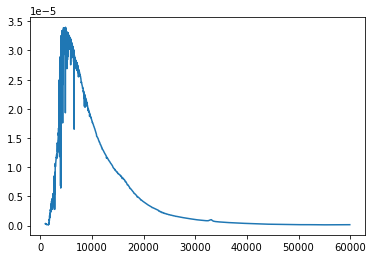

In [589]:
plt.plot(wave, spec)
# plt.plot(wave, spec)

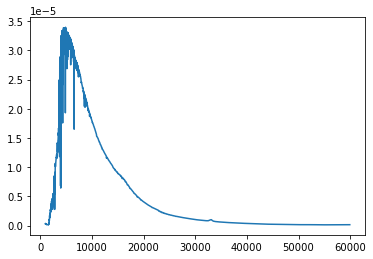

In [592]:
plt.plot(wave, spec / wave**2 * lightspeed)
# plt.plot(wave, spec)

In [517]:
_spec = spec * lightspeed / wave**2 * (3631 * 1e-23) * 1e17 # in cgs/AA units
maggies = np.trapz(
    ((wave * _spec)[None, :] * transmission_effiency[None, :]
     ), wave) / ab_zero_counts

In [518]:
-2.5 * np.log10(maggies)

array([[-44.13549034, -48.83671859, -50.6782091 , -51.41383276,
        -51.84099546]])

observate.Filter(kname='sdss_u0').ab_mag(wave, spec / dfactor)

In [403]:
maggies = np.trapz(
    spec / (4 * np.pi * (distance.value * 1e5)**2) / (1 + redshift) * transmission_effiency[2] , wave
) / ab_zero_counts[2]
-2.5 * np.log10(maggies)

16.055153287410466

In [316]:
(u.L_sun / u.Hz / u.cm**2).to(u.Jy)

3.828e+56

In [342]:
maggies = np.trapz(wave * spec * transmission_effiency[2], wave
                  ) / (4 * np.pi * distance.cgs.value**2) * 3.82e+56 / 3631

-48.59993437771777

In [ ]:
_spec = spec * lightspeed / wave**2 * (3631 * 1e-23)  # in cgs/AA units
maggies = np.trapz(
    ((wave * _spec)[None, :] * transmission_effiency[None, :]
     ), wave) / ab_zero_counts

In [334]:
ab_zero_counts

array([0.00182001, 0.00952707, 0.00945654, 0.00635115, 0.00105704])

In [339]:
model._ssp.get_mags(tage=10, redshift=1e-6,
                    bands=[f'sdss_{filt}' for filt in 'ugriz'])

array([26.59964751, 21.89842593, 20.05622479, 19.3210653 , 18.89399016])

In [301]:
model._ssp.get_mags(tage=10, bands=[f'sdss_{filt}' for filt in 'ugriz'])

array([13.49895355,  8.79774247,  6.95554641,  6.22038801,  5.79331451])

### NMF basis
```
# load SPS model  
Msps = Models.NMF(burst=False, emulator=False)
Msps._ssp_initiate()
```

In [115]:
nmf_sfh = np.loadtxt(
    '/home/jiaxuanl/Research/Packages/provabgs/src/provabgs/dat/NMF_2basis_SFH_components_nowgt_lin_Nc4.txt')

In [129]:
nmf_t = np.loadtxt('/home/jiaxuanl/Research/Packages/provabgs/src/provabgs/dat/sfh_t_int.txt')
# nmf_t = np.repeat(nmf_t[None, :], 4, axis=0)

Text(0.5, 0, 'Lookback time [Gyr]')

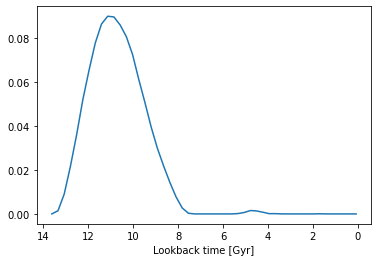

In [134]:
plt.plot(nmf_t, nmf_sfh.T[:, 3])
plt.gca().invert_xaxis()
plt.xlabel('Lookback time [Gyr]')

In [144]:
sys.path.append('/home/jiaxuanl/Research/Packages/provabgs/src/')

In [135]:
bin_edges = np.zeros(43)
bin_edges[1:-1] = 10**(6.05 + 0.1 * np.arange(41) - 9.)
bin_edges[-1] = 13.8

In [7]:
from provabgs import util
from scipy.interpolate import InterpolatedUnivariateSpline
import os

ModuleNotFoundError: No module named 'provabgs'

In [152]:
tage = 12
tlb_edges = util.tlookback_bin_edges(tage)

In [153]:
tlb_edges

array([0.00000000e+00, 1.12201845e-03, 1.41253754e-03, 1.77827941e-03,
       2.23872114e-03, 2.81838293e-03, 3.54813389e-03, 4.46683592e-03,
       5.62341325e-03, 7.07945784e-03, 8.91250938e-03, 1.12201845e-02,
       1.41253754e-02, 1.77827941e-02, 2.23872114e-02, 2.81838293e-02,
       3.54813389e-02, 4.46683592e-02, 5.62341325e-02, 7.07945784e-02,
       8.91250938e-02, 1.12201845e-01, 1.41253754e-01, 1.77827941e-01,
       2.23872114e-01, 2.81838293e-01, 3.54813389e-01, 4.46683592e-01,
       5.62341325e-01, 7.07945784e-01, 8.91250938e-01, 1.12201845e+00,
       1.41253754e+00, 1.77827941e+00, 2.23872114e+00, 2.81838293e+00,
       3.54813389e+00, 4.46683592e+00, 5.62341325e+00, 7.07945784e+00,
       8.91250938e+00, 1.12201845e+01, 1.20000000e+01])

In [172]:
dir_dat = '/home/jiaxuanl/Research/Packages/provabgs/src/provabgs/dat/'
fsfh = os.path.join(dir_dat, 'NMF_2basis_SFH_components_nowgt_lin_Nc4.txt')
fzh = os.path.join(dir_dat, 'NMF_2basis_Z_components_nowgt_lin_Nc2.txt') 
ft = os.path.join(dir_dat, 'sfh_t_int.txt')
nmf_sfh = np.loadtxt(fsfh)[:, ::-1] # basis order is jumbled up it should be [2 ,0, 1, 3]
nmf_zh  = np.loadtxt(fzh)[:, ::-1] 
nmf_t   = np.loadtxt(ft)[::-1] # look back time 

_nmf_t_lb_sfh      = nmf_t 
_nmf_t_lb_zh       = nmf_t 
_nmf_sfh_basis     = np.array([nmf_sfh[2], nmf_sfh[0], nmf_sfh[1], nmf_sfh[3]])
_nmf_zh_basis      = nmf_zh

_Ncomp_sfh = _nmf_sfh_basis.shape[0]

# SFH bases as a function of lookback time 
_sfh_basis = [
        InterpolatedUnivariateSpline(
            _nmf_t_lb_sfh, 
            _nmf_sfh_basis[i], k=1) 
        for i in range(_Ncomp_sfh)
        ]
# High time resolution grid
_t_lb_hr       = np.linspace(0., 13.8, int(5e4))
_sfh_basis_hr  = [sfh_basis(_t_lb_hr) for sfh_basis in _sfh_basis]

In [174]:
tlb_edges

array([0.00000000e+00, 1.12201845e-03, 1.41253754e-03, 1.77827941e-03,
       2.23872114e-03, 2.81838293e-03, 3.54813389e-03, 4.46683592e-03,
       5.62341325e-03, 7.07945784e-03, 8.91250938e-03, 1.12201845e-02,
       1.41253754e-02, 1.77827941e-02, 2.23872114e-02, 2.81838293e-02,
       3.54813389e-02, 4.46683592e-02, 5.62341325e-02, 7.07945784e-02,
       8.91250938e-02, 1.12201845e-01, 1.41253754e-01, 1.77827941e-01,
       2.23872114e-01, 2.81838293e-01, 3.54813389e-01, 4.46683592e-01,
       5.62341325e-01, 7.07945784e-01, 8.91250938e-01, 1.12201845e+00,
       1.41253754e+00, 1.77827941e+00, 2.23872114e+00, 2.81838293e+00,
       3.54813389e+00, 4.46683592e+00, 5.62341325e+00, 7.07945784e+00,
       8.91250938e+00, 1.12201845e+01, 1.20000000e+01])

In [175]:
sfh_basis_tlb = np.array([
    util.trapz_rebin(_t_lb_hr, _sfh_basis, edges=tlb_edges) 
    for _sfh_basis in _sfh_basis_hr])

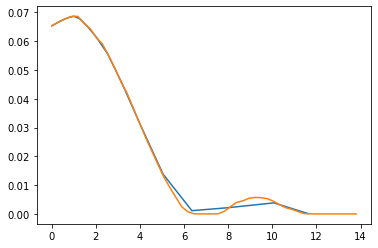

In [217]:
plt.plot(0.5 * (tlb_edges[:-1] + tlb_edges[1:]), sfh_basis_tlb[0], )

plt.plot(_t_lb_hr, _sfh_basis_hr[0])

In [199]:
tt_sfh = np.array([[10], [1], [3], [0.1]]).T

In [227]:
sfh = np.sum(np.array([tt_sfh[:,i][:,None] *
            sfh_basis_tlb[i][None,:] for i in range(4)]),
            axis=0)
sfh /= np.sum(1e9 * np.diff(tlb_edges) * sfh, axis=1)[:,None] # normalize 
# In total, formed 1 M_sun stellar mass. The unit of SFH is now `M_sun yr^{-1}`.

In [230]:
# multiply by stellar mass 
sfh *= 10**8.5

In [231]:
sfh

array([[0.05365526, 0.05365777, 0.05365894, 0.05366041, 0.05366226,
        0.05366458, 0.05366752, 0.0536712 , 0.05367585, 0.0536817 ,
        0.05368906, 0.05369832, 0.05370999, 0.05372468, 0.05374317,
        0.05376645, 0.05379575, 0.05383264, 0.05387909, 0.05393756,
        0.05401117, 0.05410384, 0.05422051, 0.05436738, 0.05455229,
        0.05478453, 0.05504152, 0.05534382, 0.05572713, 0.05622212,
        0.05656632, 0.05599994, 0.05416498, 0.05144214, 0.04723914,
        0.03969604, 0.02917912, 0.01746327, 0.01276077, 0.02030519,
        0.01452101, 0.00205736]])

In [234]:
np.log10(np.sum(sfh * np.diff(tlb_edges) * 1e9))

8.5

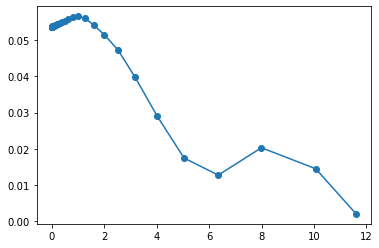

In [243]:
plt.plot(0.5 * (tlb_edges[:-1] + tlb_edges[1:]), sfh[0], marker='o')

In [240]:
tburst = np.array([4]) # Gyr, lb time
dts = np.diff(tlb_edges)
has_burst = (tburst < tlb_edges.max()) 

# log-spaced lookback time bin with burst 
iburst = np.digitize(tburst[has_burst], tlb_edges) - 1

In [244]:
sfh = np.zeros((len(tburst), len(tlb_edges) - 1))

In [246]:
sfh[has_burst, iburst] += 1. / (1e9 * dts[iburst])

In [247]:
sfh

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.08849221e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [7]:
import itertools

In [50]:
dlambda_spec = 2
wave_lo = 1000
wave_hi = 15000
wavelengths = np.arange(wave_lo, wave_hi, dlambda_spec)

In [9]:
N_samples = 5000
zred_set = np.random.uniform(0.0, 0.5, N_samples)
mass_set = np.random.uniform(1.0, 1.0, N_samples) # Fix mass to 1 M_\odot #10**(np.linspace(9, 12, 20))
tage_set = np.random.uniform(0, 1, N_samples) * cosmo.age(zred_set).value
tau_set = 10**(np.random.uniform(-2, 2, size=N_samples))
log_Z_set = np.random.uniform(-2, 0.5, size=N_samples)
dust2_set = np.random.uniform(0, 3, size=N_samples)

print('Total number of samples in parameter space:')
print(len(tau_set))

Total number of samples in parameter space:
5000


In [12]:
params_set = np.vstack([tage_set, tau_set, log_Z_set, dust2_set, mass_set, np.zeros_like(zred_set)]).T

#### Looks not bad? Try to generate some SEDs and benchmark the speed

In [11]:
sps = mock.build_sps(add_realism=False)

In [47]:
def _fsps_model_wrapper(theta):
    tage, tau, logzsol, dust2, mass, zred = theta
    model = mock.build_model(mass=mass, zred=zred, logzsol=logzsol,
                             sfh=1, tage=tage, tau=tau, 
                             add_dustabs=True, dust2=dust2,
                             uniform_priors=True)
    obs = mock.build_obs(sps, model, 
                         add_noise=False, 
                         dlambda_spec=dlambda_spec, wave_lo=wave_lo, wave_hi=wave_hi,
                         # we use true_spectrum and true_mock for emulation
                         # Noise can be added afterward
                         snr_spec=10, snr_phot=20,
                         filterset=None,
                         continuum_optimize=False)
    return np.log10(obs['true_spectrum']) 

In [48]:
_spec = _fsps_model_wrapper(params_set[20])

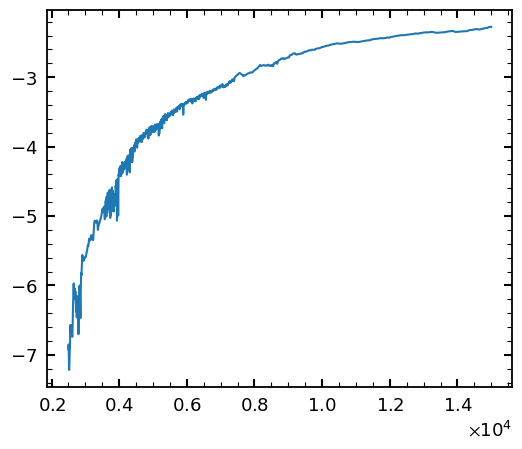

In [49]:
plt.plot(wavelengths, _spec)

In [218]:
_thetas[22]

array([10.61250654,  1.10315855, -0.24682028,  0.44613487,  1.        ,
        0.15671209])

In [219]:
tage, tau, logzsol, dust2, mass, zred = _thetas[22]
model = mock.build_model(mass=mass, zred=zred, logzsol=logzsol,
                         sfh=1, tage=tage, tau=tau, 
                         add_dustabs=True, dust2=dust2,
                         uniform_priors=True)

obs1 = mock.build_obs(sps, model, 
                     add_noise=False, 
                     dlambda_spec=dlambda_spec, wave_lo=wave_lo, wave_hi=wave_hi,
                     # we use true_spectrum and true_mock for emulation
                     # Noise can be added afterward
                     snr_spec=10, snr_phot=20,
                     filterset=None,
                     continuum_optimize=False)


model = mock.build_model(mass=mass, zred=zred, logzsol=logzsol,
                         sfh=1, tage=tage, tau=tau, 
                         add_dustabs=False, #dust2=0,
                         uniform_priors=True)

obs2 = mock.build_obs(sps, model, 
                     add_noise=False, 
                     dlambda_spec=dlambda_spec, wave_lo=wave_lo, wave_hi=wave_hi,
                     # we use true_spectrum and true_mock for emulation
                     # Noise can be added afterward
                     snr_spec=10, snr_phot=20,
                     filterset=None,
                     continuum_optimize=False)

In [211]:
model.params

{'zred': array([0.14176254]),
 'mass': array([1.]),
 'logzsol': array([-1.60051034]),
 'dust2': array([0.]),
 'sfh': array([1]),
 'tage': array([9.12673732]),
 'imf_type': array([2]),
 'dust_type': array([2]),
 'tau': array([0.02827349])}

100 s per obj per cpu

In [216]:
_specs = np.load('./train_sed/fsps.TZD.v0.1.log10spectrum.seed1.npy')

In [217]:
_thetas = np.load('./train_sed/fsps.TZD.v0.1.theta.seed1.npy')

In [82]:
_specs.shape

(10000, 7000)

In [ ]:
tage, tau, logzsol, dust2, mass, zred

In [144]:
_thetas[2]

array([0.68913809, 0.04267704, 0.48153652, 1.03508129, 1.        ,
       0.14545237])

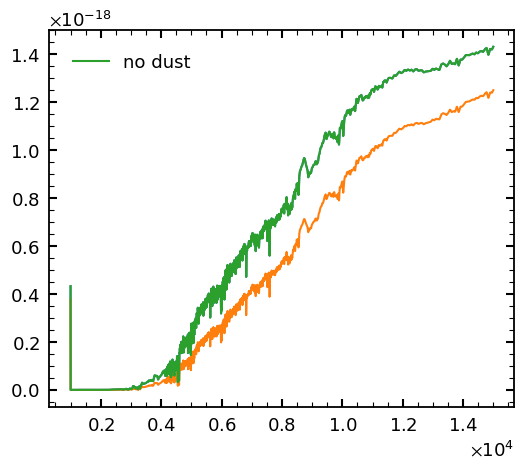

In [222]:
plt.plot(wavelengths, 10**_specs[22])
plt.plot(wavelengths, obs1['true_spectrum'])
plt.plot(wavelengths, obs2['true_spectrum'], label='no dust')

plt.legend()

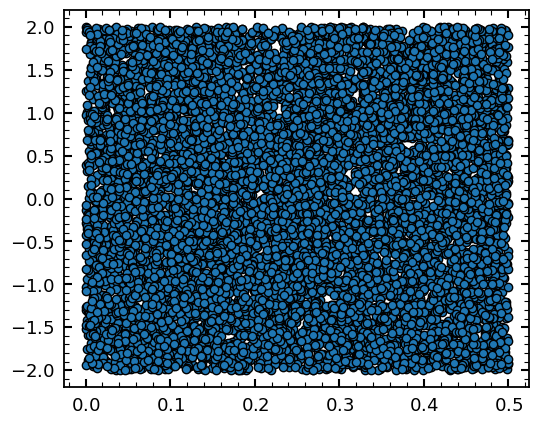

In [97]:
plt.scatter(_thetas[:, 5], np.log10(_thetas[:, 1]))

In [15]:
import time

In [16]:
start = time.time()
# This will take forever
obs_set = []
# we start with a simple model: tau-SFH, no dust attenuation and emission, no nebular emission
for i in range(N_samples):
    zred, mass, tage, tau, logzsol, dust2 = params_set[i]
    model = mock.build_model(mass=mass, zred=zred, logzsol=logzsol,
                             sfh=1, tage=tage, tau=tau, 
                             add_dustabs=True, dust2=dust2,
                             uniform_priors=True)
    obs = mock.build_obs(sps, model, add_noise=False, 
                         dlambda_spec=dlambda_spec, wave_lo=wave_lo, wave_hi=wave_hi,
                         # we use true_spectrum and true_mock for emulation
                         # Noise can be added afterward, with a better noise model
                         snr_spec=10, snr_phot=20,
                         filterset=sdss, 
                         continuum_optimize=False)
    obs_set.append(obs)

with open(f'./train_sed/train_sed_dust_Z_{N_samples}.pkl', 'wb') as f:
    pickle.dump(obs_set, f)
    f.close()
    
end = time.time()
print('Elapsed time = ', end - start)

Elapsed time =  608.2706341743469


In [17]:
len(obs_set)

5000

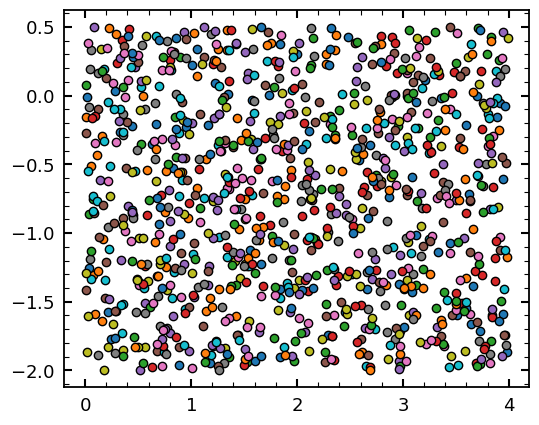

In [18]:
for obs in obs_set[1000:2000]:
    plt.scatter(obs['mock_params']['dust2'][0], obs['mock_params']['logzsol'][0])

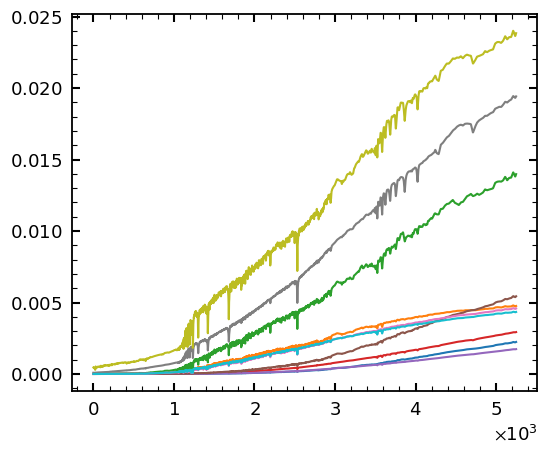

In [19]:
for obs in obs_set[1000:1010]:
    plt.plot(obs['true_spectrum'])

In [ ]:
NOW WE HAVE TWO SAMPLES, EACH WITH 5000 SEDS. TO DO TOMORROW;.

## Load obs_set, and translate it into numpy arrays

In [19]:
with open('./train_sed/train_sed_1600.pkl', 'rb') as f:
    obs_set = pickle.load(f)
    f.close()

No handles with labels found to put in legend.


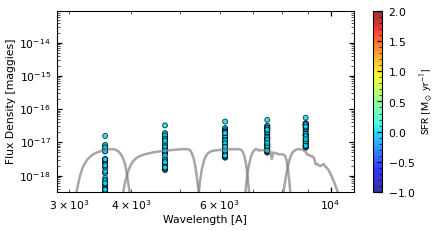

In [20]:
obs = obs_set[0]

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(8, 4))

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 40)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
#     sct = plt.scatter(wphot, ob['maggies'],
#          #label='All observed photometry',
#          marker='o', alpha=0.8, vmin=1, vmax=10,
#          c=np.ones_like(wphot) * ob['mock_params']['tau'], cmap='jet')
    sct = plt.scatter(wphot, ob['maggies'],
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-1, vmax=2,
         c=np.ones_like(wphot) * sfr, cmap='jet')
    
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
    
# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin / 10, ymax * 1000])
#plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best')

Text(0.5, 0.98, 'Randomly selected 80 SEDs in the traning sample')

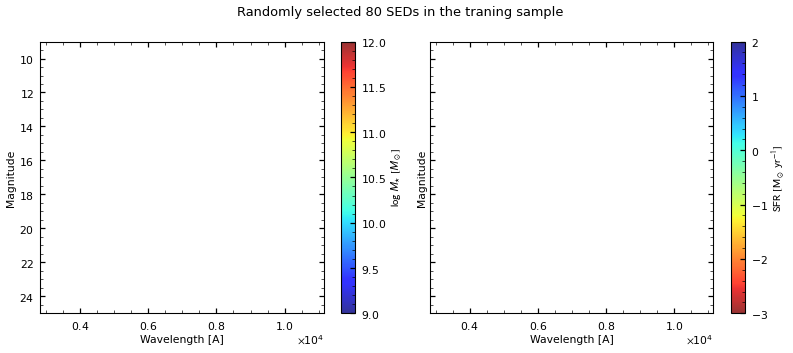

In [21]:
obs = obs_set[0]
wphot = obs["phot_wave"]
# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax =  -2.5 * np.log10(obs["maggies"].min())*0.8, -2.5 * np.log10(obs["maggies"].max())/0.4


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plt.sca(axes[0])

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 80)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         marker='o', alpha=0.8, vmin=9, vmax=12,
         c=np.ones_like(wphot) * np.log10(ob['mock_params']['mass']), cmap='jet')
plt.colorbar(sct, label=r'$\log\, M_{\star}\ [M_\odot]$')
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Magnitude')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])

plt.sca(axes[1])
# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 80)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-3, vmax=2,
         c=np.ones_like(wphot) * np.log10(sfr), cmap='jet_r')
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Magnitude')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])


plt.suptitle('Randomly selected 80 SEDs in the traning sample')

In [22]:
# t, sfr, cmf = params_to_sfh(model.params, 
#                             time=np.linspace(0, cosmo.age(model.params['zred']).value, 30), 
#                             agebins=None)

## Translate the `obs_set` into numpy arrays of parameters, SEDs, and spectra

Spectrum: `dlambda_spec=2.0, wave_lo=3800, wave_hi=7000.0`. Length = 1600

`wavelength = np.arange(3800, 7000, 2)`.

Files are stored at `/scratch/gpfs/jiaxuanl/Data/popsed/train_sed`

In [23]:
obs = obs_set[10]
len_spec = len(obs['wavelength'])
len_phot = len(obs['phot_wave'])

In [25]:
%%time
# Array storing all spectra
spec_arr = np.zeros((len(obs_set), len_spec))
for i, obs in enumerate(obs_set):
    spec_arr[i] = np.log10(obs['true_spectrum'])
    
# Need to take log of the spectrum flux density

CPU times: user 366 ms, sys: 869 ms, total: 1.24 s
Wall time: 1.28 s


In [26]:
%%time
# Array storing all SEDs
phot_arr = np.zeros((len(obs_set), len_phot))
for i, obs in enumerate(obs_set):
    phot_arr[i] = obs['true_maggies']

CPU times: user 1.9 ms, sys: 991 µs, total: 2.89 ms
Wall time: 2.89 ms


In [27]:
list(obs['mock_params'].keys())

['zred',
 'mass',
 'logzsol',
 'dust2',
 'sfh',
 'tage',
 'imf_type',
 'dust_type',
 'tau']

In [28]:
keys = ['zred', 'mass', 'logzsol', 'dust2', 'sfh', 
        'tage', 'imf_type', 'dust_type', 'tau'] # , 'sfr'

In [29]:
%%time
param_arr = np.array([[float(obs['mock_params'][key]) for key in keys] for obs in obs_set])

param_arr[:, -1] = np.log10(param_arr[:, -1]) # tau to log(tau)

CPU times: user 9.43 ms, sys: 127 µs, total: 9.56 ms
Wall time: 9.74 ms


In [30]:
from sklearn.model_selection import train_test_split

In [31]:
with open('./train_sed/log_spec_all.npy', 'wb') as f:
    np.save(f, spec_arr)

with open('./train_sed/phot_all.npy', 'wb') as f:
    np.save(f, phot_arr)
    
with open('./train_sed/param_all.npy', 'wb') as f:
    np.save(f, param_arr)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(spec_arr, param_arr, test_size=0.20, random_state=42)

In [33]:
with open('./train_sed/log_spec_train.npy', 'wb') as f:
    np.save(f, X_train)
    
with open('./train_sed/log_spec_vali.npy', 'wb') as f:
    np.save(f, X_test)
    
with open('./train_sed/param_train.npy', 'wb') as f:
    np.save(f, y_train)
    
with open('./train_sed/param_vali.npy', 'wb') as f:
    np.save(f, y_test)

In [34]:
# with open('./train_sed/phot_1600.npy', 'wb') as f:
#     np.save(f, phot_arr)
    
# with open('./train_sed/log_spec_1600.npy', 'wb') as f:
#     np.save(f, spec_arr)
    
# with open('./train_sed/param_1600.npy', 'wb') as f:
#     np.save(f, param_arr)

**Galaxies with SFR=0 and very small $\tau$ ($\tau$ < 0.02) just have zero fluxes. Need to remove them??**

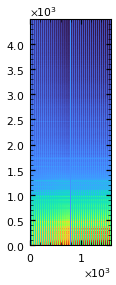

In [35]:
from astropy.visualization import simple_norm
test = spec_arr / np.mean(spec_arr, axis=1)[:, np.newaxis]
#norm = simple_norm(spec_arr / np.mean(spec_arr, axis=1)[:, np.newaxis], 'sqrt')
plt.imshow(test.T)#, norm=norm)

### Some tests

In [7]:
dlambda_spec = 2
wave_lo = 1500
wave_hi = 12000
wavelengths = np.arange(wave_lo, wave_hi, dlambda_spec)

In [434]:
import torch
from torchinterp1d import Interp1d

In [435]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [154]:
redshift = 0.1

In [146]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
params = np.load('./train_sed/param_all.npy')[:, ~flag]
log_spec_all = np.load('./train_sed/log_spec_all.npy')

In [147]:
params[0]

array([ 1., -2.])

In [155]:
param = torch.Tensor([[5, 0, np.log10(1), redshift]]).to('cuda')
spec1 = speculator._predict_spec_with_mass_redshift(param)

tensor([[1.9681e+15]], device='cuda:0')


In [156]:
model = mock.build_model(mass=1, zred=redshift, logzsol=-0.5,
                         tage=5, tau=10**0, 
                         sfh=1, add_dustabs=False,
                         #dust2=0.2,
                         uniform_priors=True)
obs = mock.build_obs(sps, model, add_noise=False, 
                     dlambda_spec=dlambda_spec, wave_lo=wave_lo, wave_hi=wave_hi,
                     # we use true_spectrum and true_mock for emulation
                     # Noise can be added afterward, with a better noise model
                     snr_spec=10, snr_phot=20,
                     filterset=sdss, 
                     continuum_optimize=False)

In [150]:
wave_rest = wavelengths
wave_stretch = wave_rest / (1 + redshift)
wave_stretch

array([ 1363.63636364,  1365.45454545,  1367.27272727, ...,
       10903.63636364, 10905.45454545, 10907.27272727])

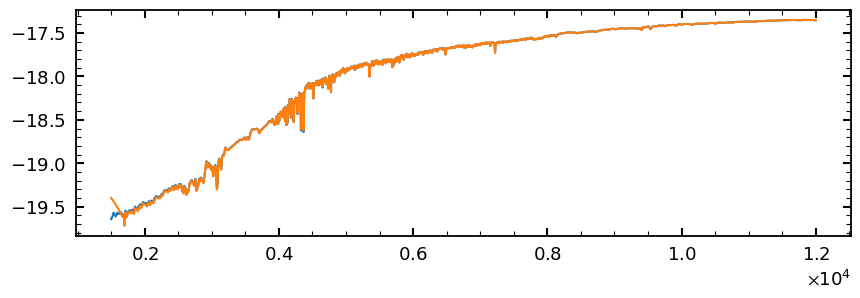

In [157]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
#plt.plot(wave_rest, np.log10(obs0['true_spectrum'] / dfactor))
plt.plot(wave_rest, np.log10(obs['true_spectrum']))
plt.plot(wave_rest, np.log10(spec1[0].detach().cpu().numpy()))
#plt.plot(wave_rest, np.log10(10**log_spec_all[0] / dfactor))